In [112]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)


# print(os.getcwd())

In [113]:
len_cluster = 9
feature_cols = ['CPU1TempTemperatureReading-TemperatureReading', 'CPU2TempTemperatureReading-TemperatureReading', 'CUPSSystemUsage-CPUUsage', 'CUPSSystemUsage-IOUsage', 'CUPSSystemUsage-MemoryUsage', 'CUPSSystemUsage-SystemUsage', 'DIMMSocketA1TemperatureReading-TemperatureReading', 'DIMMSocketA2TemperatureReading-TemperatureReading', 'DIMMSocketA3TemperatureReading-TemperatureReading', 'DIMMSocketA4TemperatureReading-TemperatureReading', 'DIMMSocketA5TemperatureReading-TemperatureReading', 'DIMMSocketA6TemperatureReading-TemperatureReading', 'Fan1RPMReading-RPMReading', 'Fan2RPMReading-RPMReading', 'Fan3RPMReading-RPMReading', 'Fan4RPMReading-RPMReading', 'Fan5RPMReading-RPMReading', 'Fan6RPMReading-RPMReading', 'PowerMetricsTotalStoragePower-SystemPowerConsumption', 'PowerMetricsTotalStoragePower-TotalCPUPower', 'PowerMetricsTotalStoragePower-TotalMemoryPower', 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio', 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower']

centers_df = pd.read_csv("data/data_cluster.csv")

centers_df = centers_df[feature_cols]

## MinMax norm
for c in feature_cols:
    centers_df[c] = MinMaxScaler().fit_transform(centers_df[c].values.reshape((centers_df[c].shape[0], -1)))

## num of clusters   
len_cluster = centers_df.shape[0]

## convert pandas to list
center_list = [centers_df.iloc[i].values for i in range(len_cluster)]




In [114]:
def find_cluster_(point):
    return np.argmin([np.linalg.norm(point - center_list[i]) for i in range(len_cluster)])

def find_cluster_matrix_(matrix):
    return np.array(list(map(find_cluster, matrix)))


def find_cluster(point):
    distance_list = np.array([np.linalg.norm(point - center_list[i]) for i in range(len_cluster)])
    _sum = np.sum(distance_list)
    distance_probs = 1 / (distance_list+1)
    distance_probs = distance_probs / np.sum(distance_probs)
    return distance_probs

def find_cluster_matrix(matrix):
    return np.array(list(map(find_cluster, matrix)))


# read pickle
with open('output/X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('output/X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    

with open('output/explainer.pkl', 'rb') as handle:
    explainer = pickle.load(handle)

with open('output/shap_values.pkl', 'rb') as handle:
    shap_values = pickle.load(handle)
    
    


In [115]:
shap_values_np = np.array(shap_values)
shap.initjs()

In [116]:
shap_values_np.shape

(9, 180, 23)

# Show feature importance for each feature of each class 

In [117]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")
shap_importance

,feature_name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,CPU1TempTemperatureReading-TemperatureReading,0.830860,0.527753,0.457017,0.475903,0.136966,0.154510,0.835850,0.634465,0.585580
1,CPU2TempTemperatureReading-TemperatureReading,0.959287,0.601712,0.544154,0.601625,0.356939,0.370983,0.786776,0.620000,0.573502
2,CUPSSystemUsage-CPUUsage,0.656665,0.379782,0.352679,0.415063,0.791378,0.889363,1.485843,0.836104,0.521439
3,CUPSSystemUsage-IOUsage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,CUPSSystemUsage-MemoryUsage,0.644793,0.370371,0.347635,0.401967,0.775162,0.878345,1.474384,0.837865,0.521428
5,CUPSSystemUsage-SystemUsage,0.662614,0.375247,0.352732,0.411058,0.798517,0.891382,1.488210,0.847793,0.525387
6,DIMMSocketA1TemperatureReading-TemperatureReading,0.462956,0.833364,0.402243,0.134212,0.072637,0.065898,0.130118,0.092738,0.106212
7,DIMMSocketA2TemperatureReading-TemperatureReading,1.219884,0.615782,0.476971,0.486706,0.744564,0.822504,1.136000,0.811983,0.777252
8,DIMMSocketA3TemperatureReading-TemperatureReading,0.458209,0.827558,0.406216,0.145828,0.073569,0.065889,0.129233,0.095440,0.106538
9,DIMMSocketA4TemperatureReading-TemperatureReading,1.635824,0.557767,0.308526,0.329401,0.547739,0.815105,0.988355,0.786677,0.765045


In [118]:
import plotly.graph_objects as go

x = list(range(len_cluster))

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each cluster, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

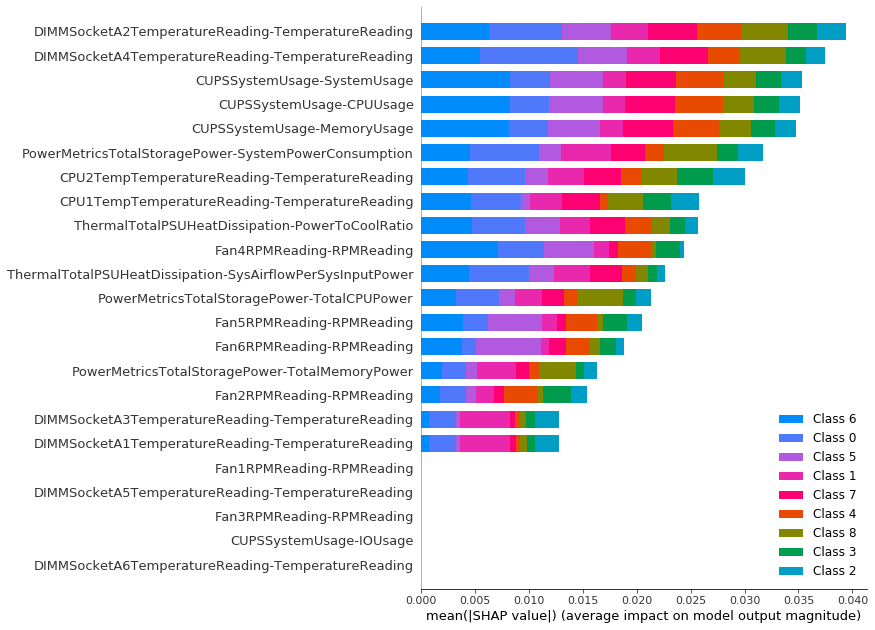

In [119]:
## Feature importance of each feature, colored by cluster

shap.summary_plot(shap_values, X_test, max_display =  len(feature_cols), show=False, plot_type = "bar",feature_names=feature_cols)

cluster 0


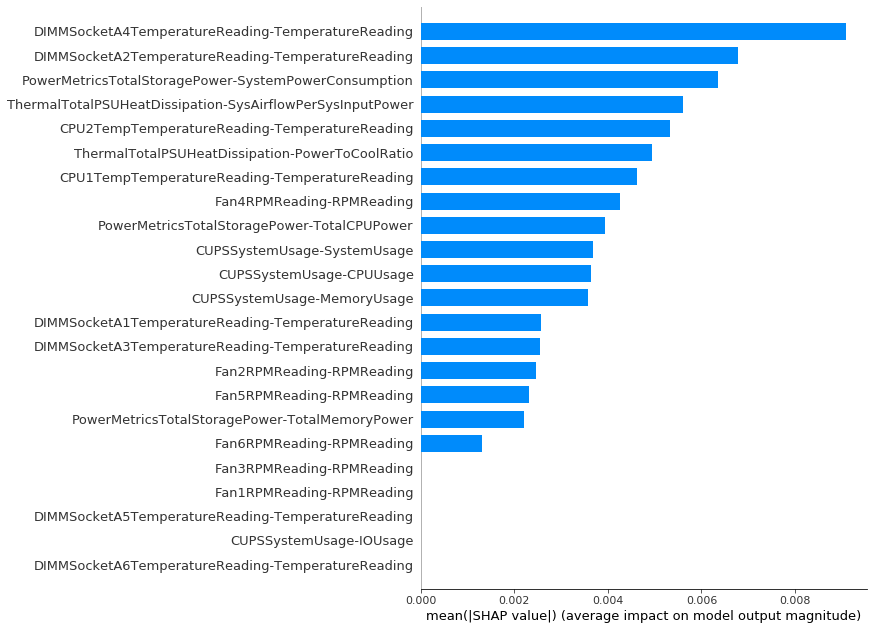



cluster 1


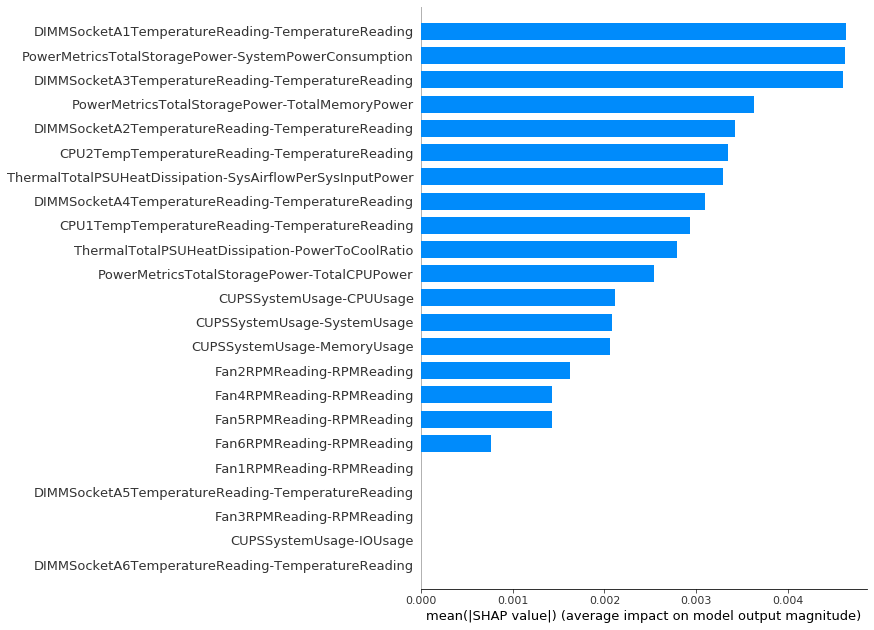



cluster 2


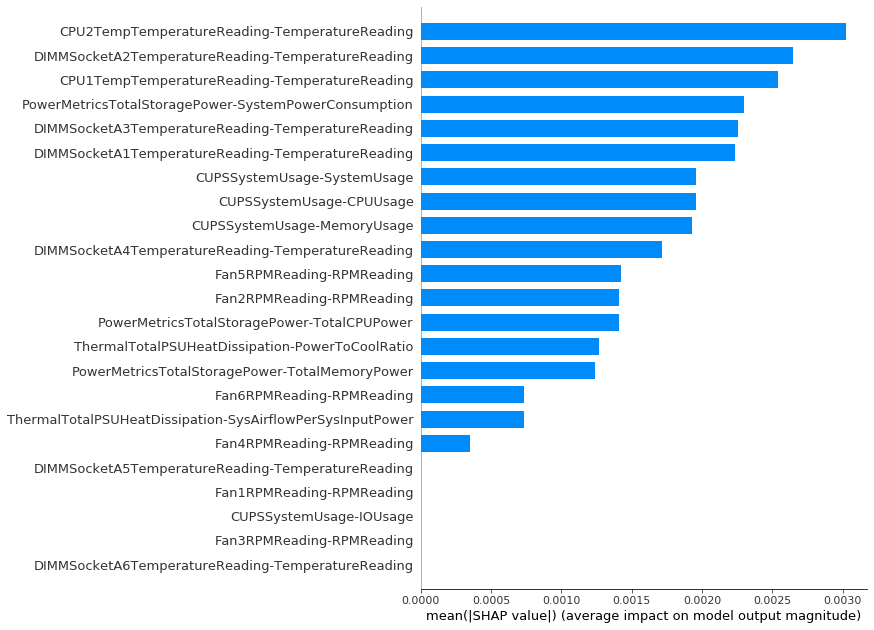



cluster 3


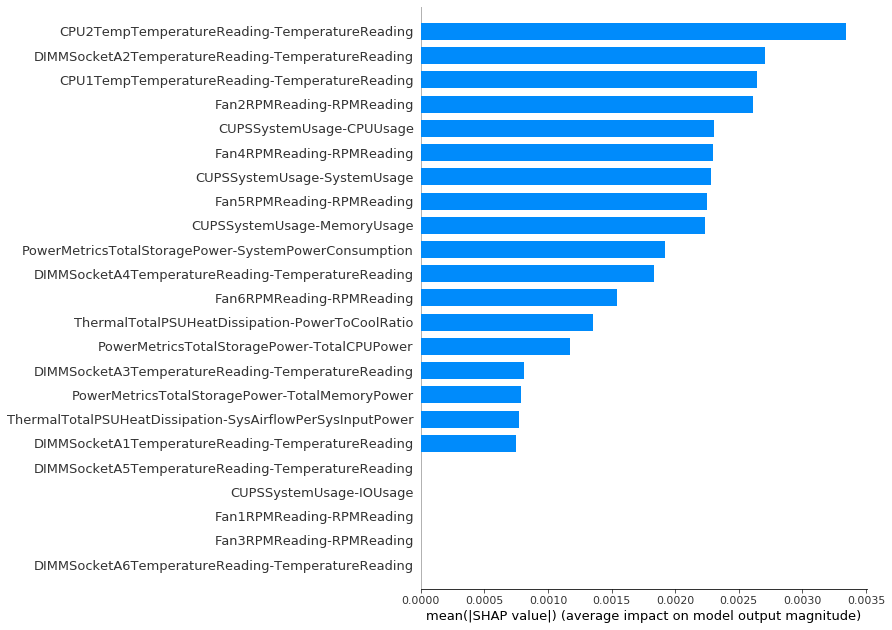



cluster 4


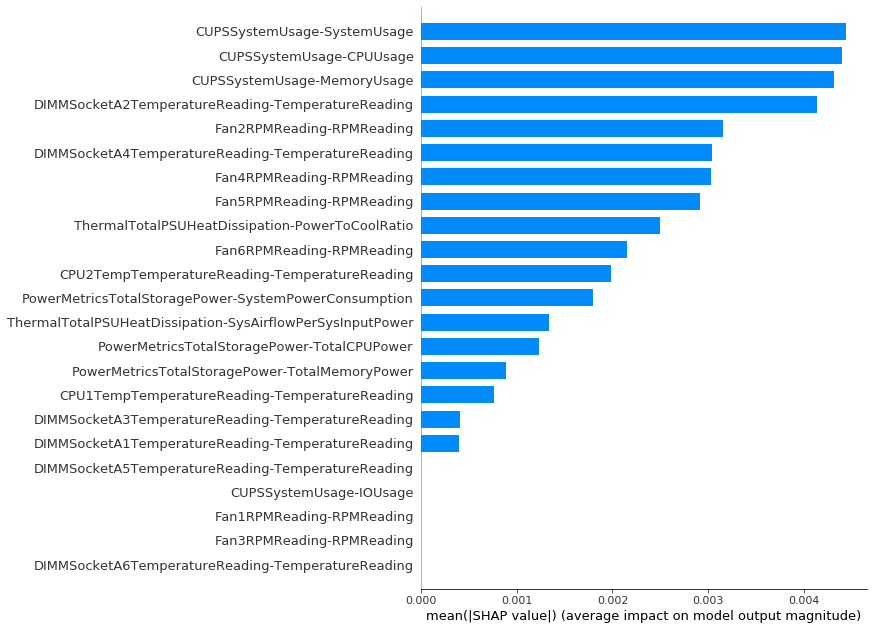



cluster 5


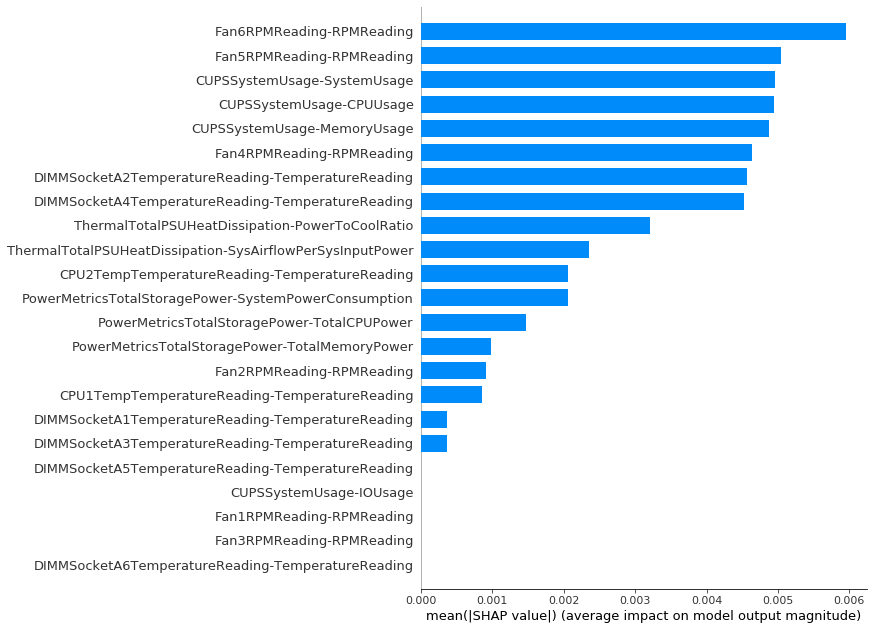



cluster 6


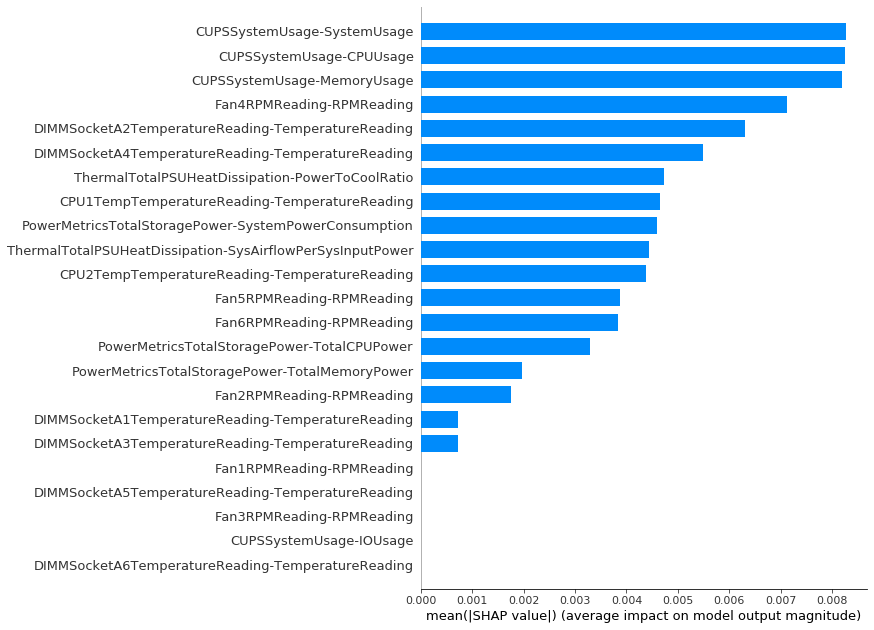



cluster 7


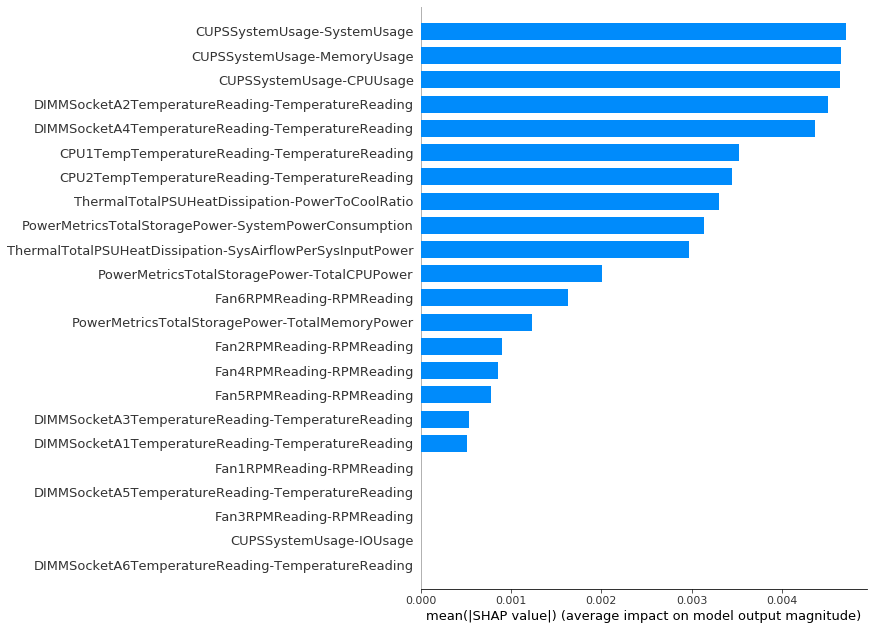



cluster 8


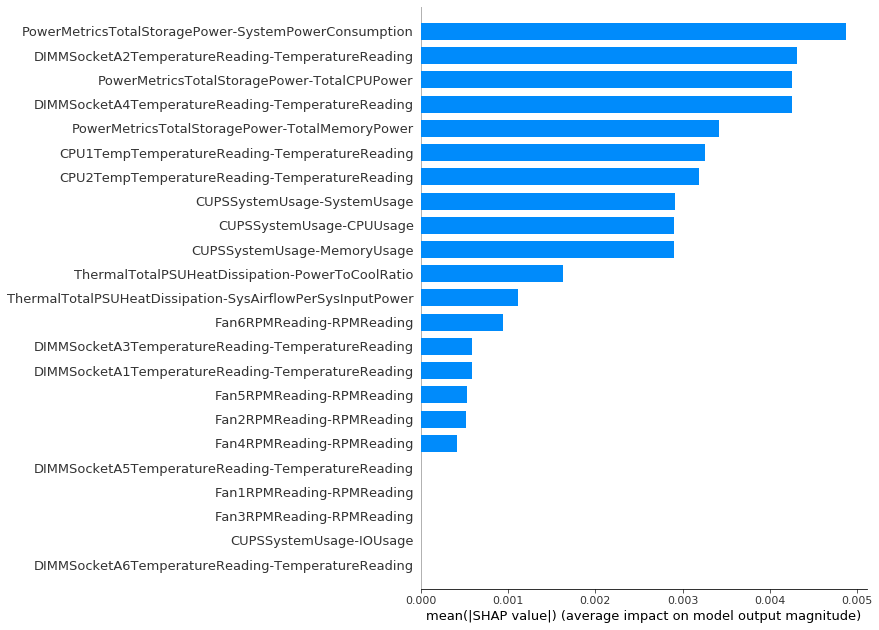

In [120]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_test, max_display =  len(feature_cols), show=False, plot_type = "bar",feature_names=feature_cols)
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [121]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]

for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

In [122]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]

for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name=f"cluster {i}", mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


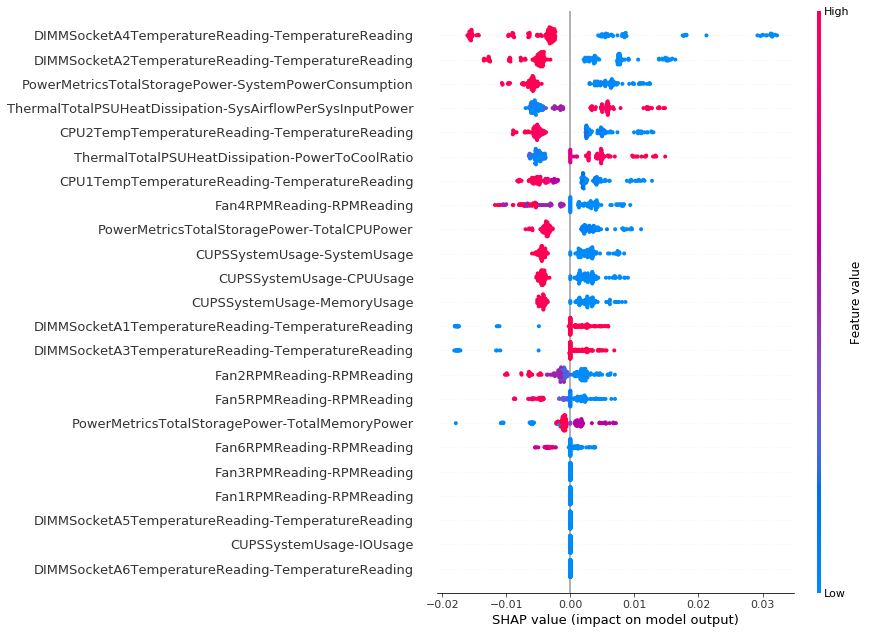



cluster 1


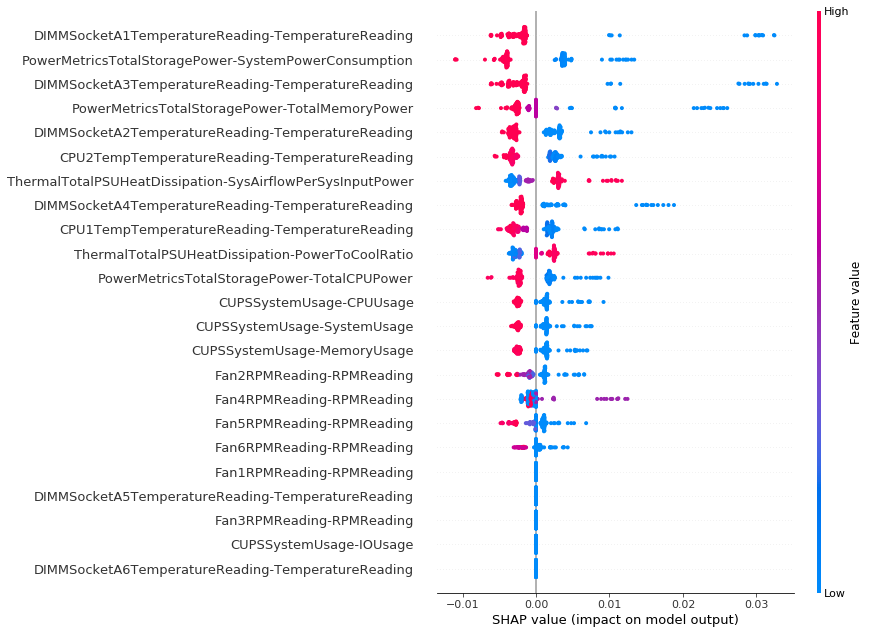



cluster 2


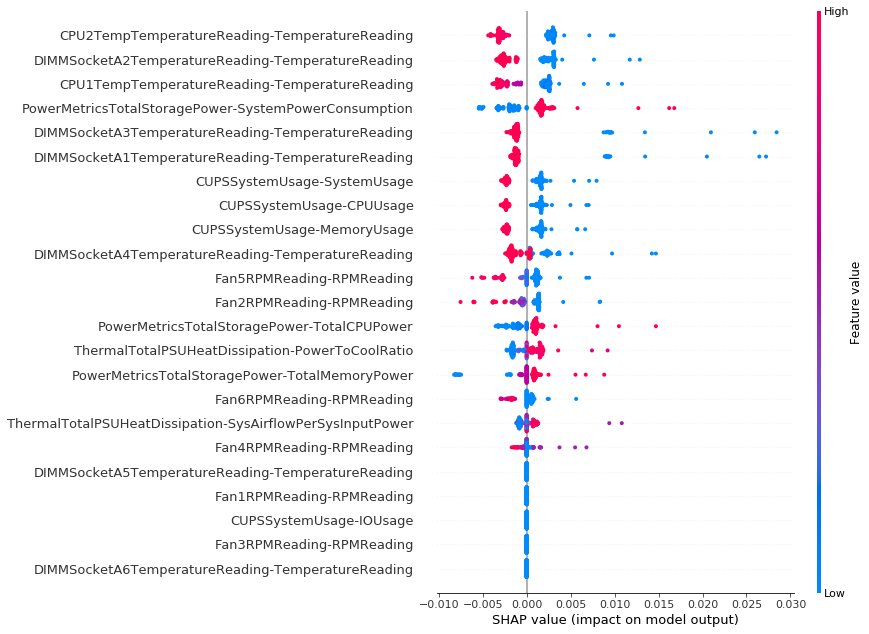



cluster 3


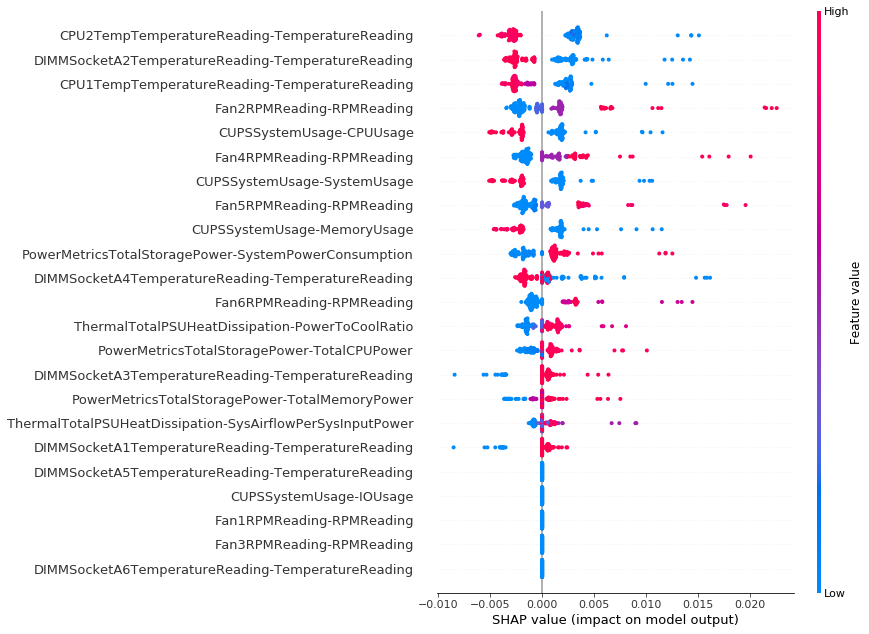



cluster 4


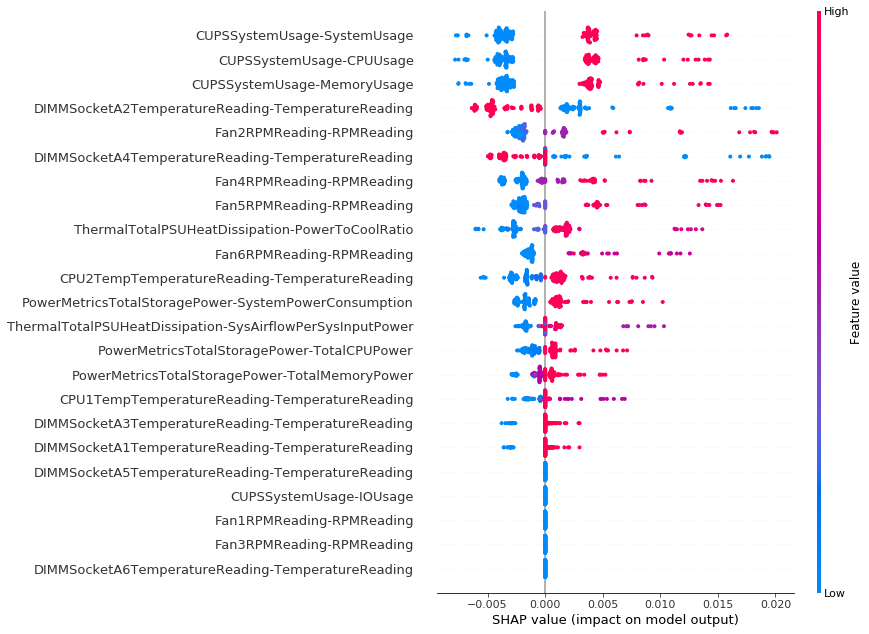



cluster 5


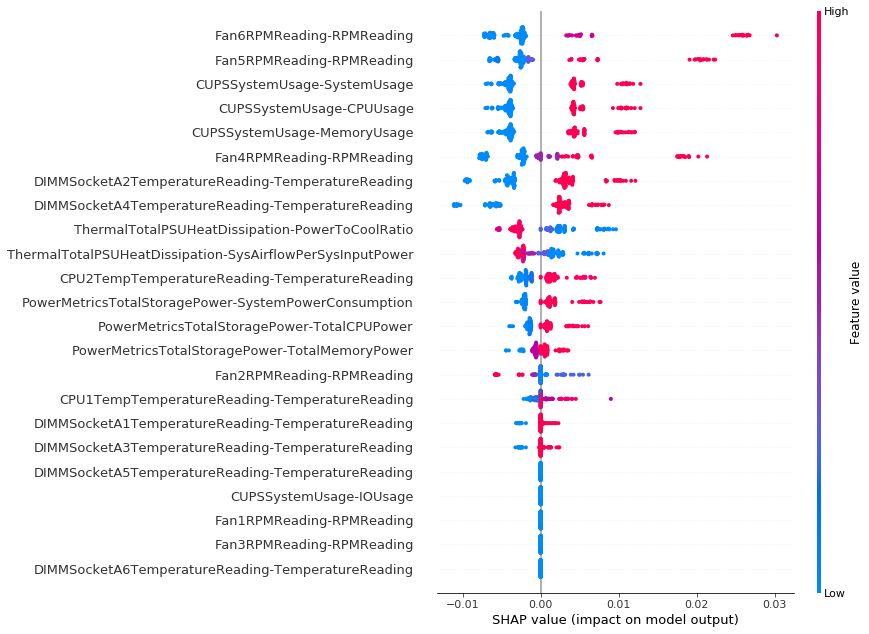



cluster 6


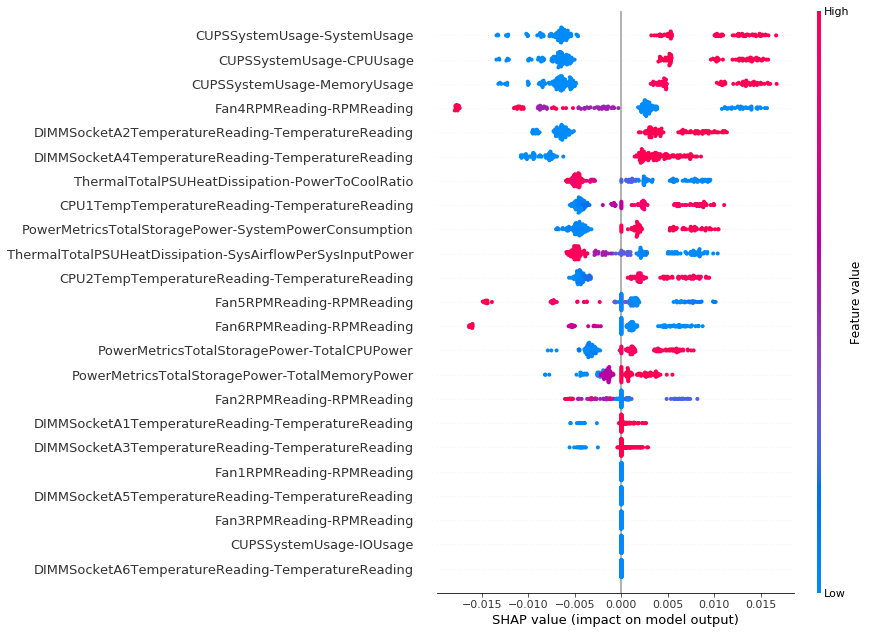



cluster 7


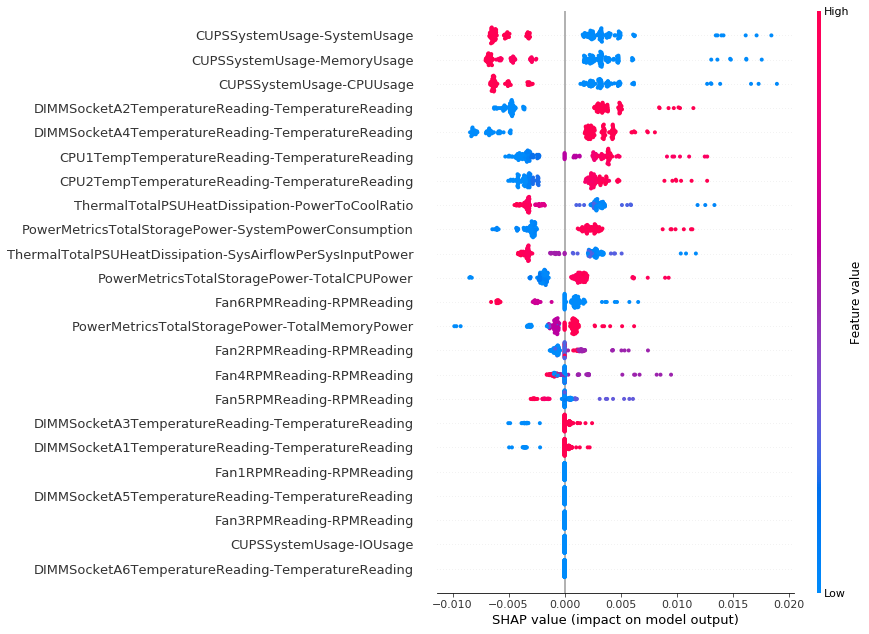



cluster 8


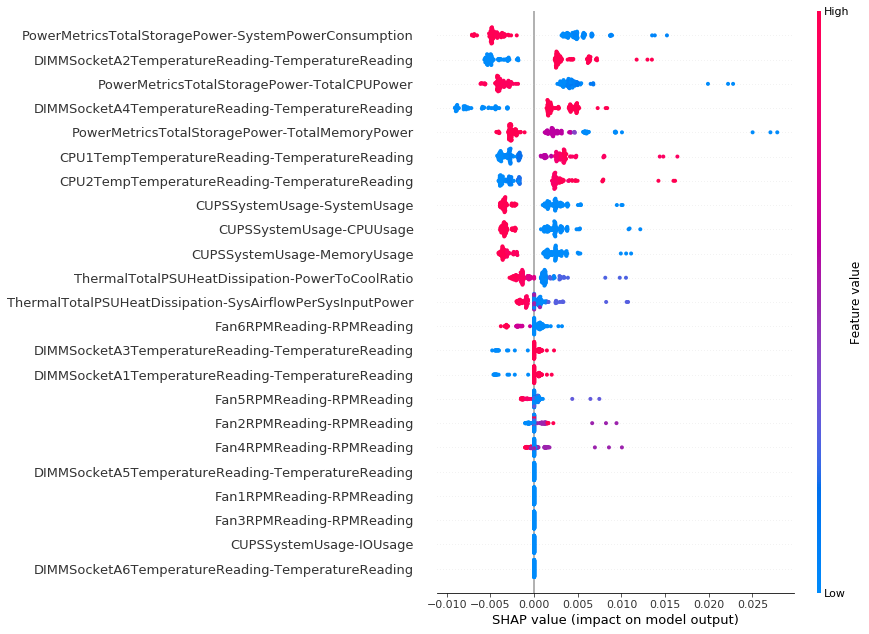

In [123]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_test, max_display = len(feature_cols), show=False, plot_type = "dot", feature_names=feature_cols)
    print("cluster", i)
    plt.show(f)
    print("\n")